## Introduction  

### Session purpose
In this session, we are introducing principle component analysis (PCA) and decision tree model. 
This notebook has many sections empty with hints on how to complete them. We also provide a complete notebook which you can 
refer to when you try to complete this exercise notebook.

### Session contents
In this session, we will be covering the following topics:

1. Data transformation - Principle Component Analysis;
2. Multiclass classification;
3. Decision tree classifier;
4. Visualizing decision tree model;

### About the data set  
The data set is actual satellite imagery of our home city of Asheville, taken from Landsat 8, an imaging satellite that was launched in 2013.

Check out the following links for more information: https://www.usgs.gov/land-resources/nli/landsat/landsat-8?qt-science_support_page_related_con=0#qt-science_support_page_related_con

https://landsat.gsfc.nasa.gov/landsat-data-continuity-mission/ 

Before we starts to read in the data and create our first classifier, we need to load libraries that will be used in the notebook. We will heavily rely on [**caret**](https://topepo.github.io/caret/index.html) library in R for model training. *caret* is a powerful wrapper package which calls hunders of machine learning packages in R and simplify model training and application process.  


In [1]:
library(caret); library(rpart)                                    # pacakge for ML model training
library(ggplot2); library(cowplot); library(rattle)               # package for visualization
library(readr); library(dplyr)                                    # package for data handeling

Loading required package: lattice

Loading required package: ggplot2


********************************************************

Note: As of version 1.0.0, cowplot does not change the

  default ggplot2 theme anymore. To recover the previous

  behavior, execute:
  theme_set(theme_cowplot())

********************************************************


Loading required package: tibble

Loading required package: bitops

Rattle: A free graphical interface for data science with R.
Version 5.4.0 Copyright (c) 2006-2020 Togaware Pty Ltd.
Type 'rattle()' to shake, rattle, and roll your data.


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




## 1 - Review of the data  

In this tutorial, we are still using the same dataset that we used during our previous training on land cover classification for Asheville area. Instead of going through each step in details, we will just do a quick review of the data.  

### 1.1 - Data ingest 

First thing first, we will read in the data for this notebook which is included in this Github repository. The data file [*NC_L8_GroundTruth.csv*](https://github.com/geo-yrao/ML4ES-tutorials/blob/master/01-Data/NC_L8_GroundTruth.csv) contains sampled pixels in western North Carolina. The data contains both the multispectral reflectance from Landsat-8 OLI data and corresponding land cover types from USGS Cropland Data Layer (CDL). We can see the first 10 lines of the data. Our data contains the location (*"Latitude","Longitude"*), land cover type (*"Class"*), and reflectance of six OLI channels (*"B1"~"B6"*). Let's first check how the data frame looks like.


In [2]:
## Here, we read in the data pairs between reflectance (scale factor: 0.0001) and land cover types
fname <- "~/00-Data/NC_L8_GroundTruth.csv"
AVLData <- read_csv(fname); head(AVLData, 10)

Warning message:
“Missing column names filled in: 'X1' [1]”
Parsed with column specification:
cols(
  X1 = col_double(),
  Latitude = col_double(),
  Longitude = col_double(),
  Class = col_double(),
  B1 = col_double(),
  B2 = col_double(),
  B3 = col_double(),
  B4 = col_double(),
  B5 = col_double(),
  B6 = col_double()
)



X1,Latitude,Longitude,Class,B1,B2,B3,B4,B5,B6
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,35.51477,-82.68045,0,127,150,550,226,3609,1441
2,35.75398,-82.52043,0,81,115,426,170,2913,1110
3,35.71063,-82.30566,0,156,220,538,477,2492,2077
4,35.51281,-82.41386,0,245,280,663,507,2732,1531
5,35.52064,-82.85318,0,148,181,534,265,3320,1457
6,35.61906,-82.80788,0,202,289,651,522,3047,2251
7,35.55420,-82.50479,0,208,250,521,408,2905,1738
8,35.56040,-82.30077,0,60,91,486,184,3431,1342
9,35.54573,-82.50511,0,122,155,463,219,3385,1264


The following table present the information about the six [OLI chanles](https://en.wikipedia.org/wiki/Landsat_8) included in the data. The reflectance data can provide unique information to charaterize different land cover types.

| Channel No. | Channel Name | Wavelength |
|-:|-:|:-:|
|B1|Coastal/Areasol|0.433 – 0.453 μm| 
|B2|Blue|0.450 – 0.515 μm|
|B3|Green|0.525 – 0.600 μm|
|B4|Red|0.630 – 0.680 μm|
|B5|Near Infrared|0.845 – 0.885 μm|
|B6|Short Wavelength Infrared|1.560 – 1.660 μm|  

In our data, there are five different land cover types as listed in the table below.  

| Class No. | Land Cover Type |
|-:|-:|
|0|Forest| 
|1|Corn|
|2|Soy|
|3|Development/Urban|
|4|Water| 

In this tutorials, we merge the two crop types (i.e., corn and soy) together to form a new class as "Crop" considering that they have quite similar spectral features which might lead to misclassification between them.

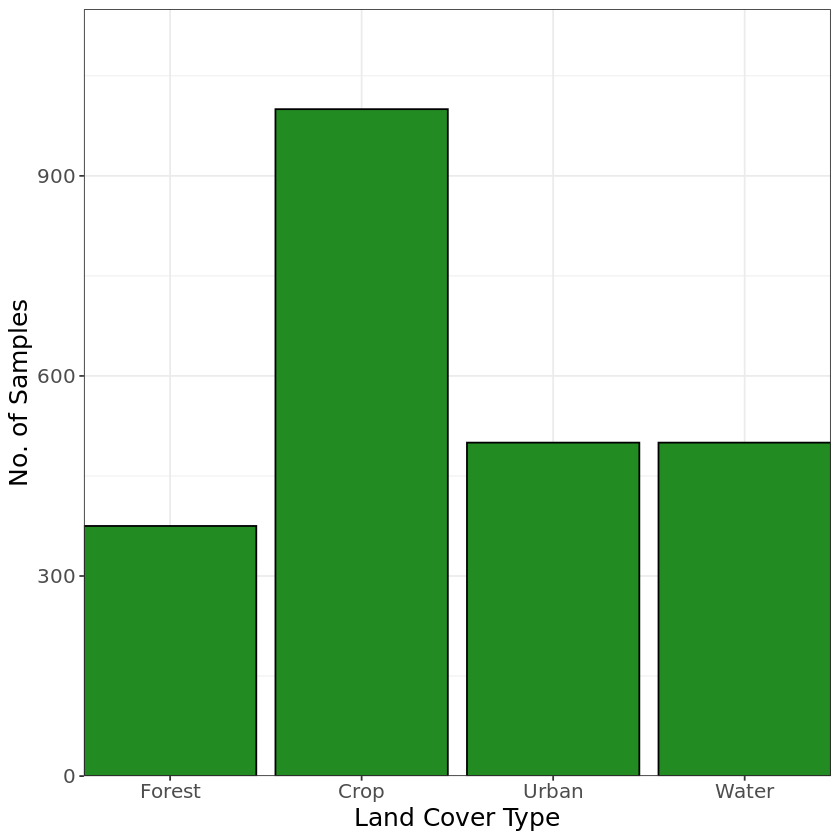

In [3]:
## Create a new variable for merged_class while preserve the original class label from data
## Merge corn and soy into crop class (with code = 12) and conver it to a factor
AVLData$merged_class <- factor(if_else((AVLData$Class == 1 | AVLData$Class == 2), 12, AVLData$Class),
                               levels = c(0,12,3,4), labels = c("Forest", "Crop", "Urban", "Water"))

# Show the histogram of different land cover types using ggplot2
AVLData %>% ggplot() + geom_bar(aes(merged_class), color="black", fill="forestgreen") +
  labs(x="Land Cover Type", y="No. of Samples") + coord_cartesian(ylim=c(0,1150), expand=F) +
  theme_bw() + theme(text=element_text(size=15))

In [4]:
## We are now spliting the data set into training and testing data set
trainIndex <- createDataPartition(AVLData$merged_class, p=0.8, list=FALSE, times = 1)

## 80% data is for training while 20% data is for independent testing
trainData <- AVLData[trainIndex,]; testData <- AVLData[-trainIndex,]

Warning message:
“The `i` argument of ``[`()` can't be a matrix as of tibble 3.0.0.
Convert to a vector.
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated.”


### 1.2 - Visualize the raw features  

Typically, we need to examine the features in our dataset (i.e., the reflectance data from different channels) to make sure 
that the features are appropriate.  

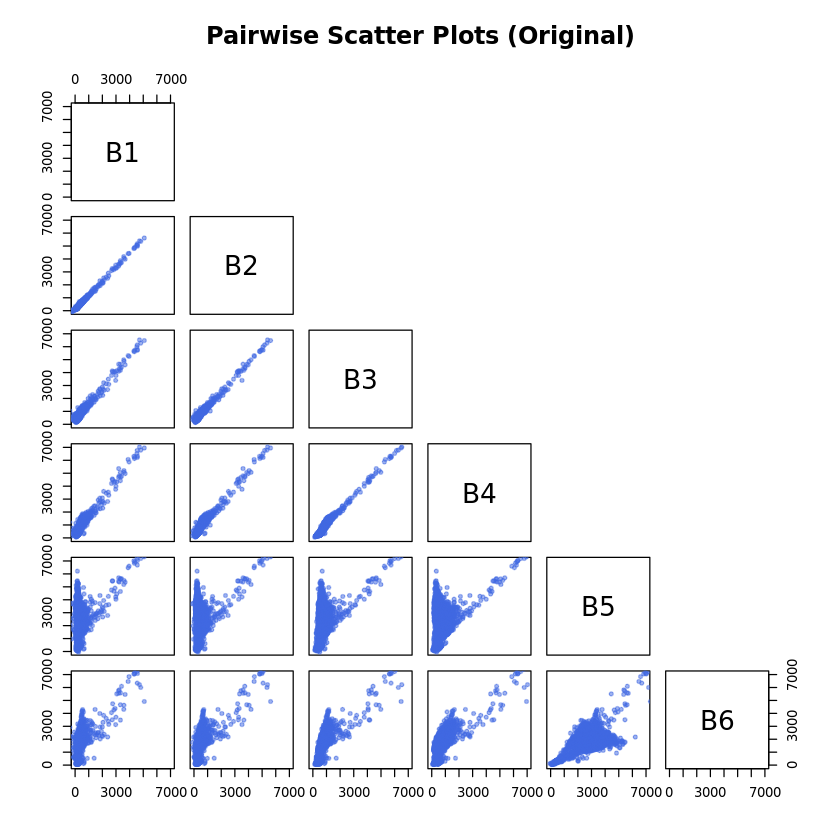

In [5]:
## In R base package, we can use the "pairs" function to visualize the pairwise scatter plot between each feature
## This pairwise scatter plot will inform us if there are any correlations amongst different features.
AVLData %>% select(B1:B6) %>% pairs(upper.panel=NULL, xlim=c(0,7000), ylim=c(0,7000), 
                                    pch=20, main="Pairwise Scatter Plots (Original)", 
                                    col=rgb(65/255.,105/255.,225/255.,0.5))  ## We use rgb() function to increase the 
                                                                             ## transparency of the royalblue color


This pairwise plot informs us that there are multiple channels that show strong linear relationship among them.  
This is a signal that we should either selecting a subset of the features or perform certain transformation of the features 
to produce a more representive feature space.  

## 2 - Feature extraction/transformation  

In this notebook, we will mainly focus on [principle component analysis (PCA)](https://towardsdatascience.com/a-one-stop-shop-for-principal-component-analysis-5582fb7e0a9c). PCA is a classic method for dimension reduction and feature transformation. It can help reduce the number of variables used in the analysis while retain the most of the information in a data set. It is most useful when you have a large data set and do not know which variable should be eliminated for your analysis.  

PCA is included in the *caret* package as a method for data preprocessing. We can perform PCA analysis using *caret::preProcess()* function.  


In [6]:
## We only need the features of B1~B6 for the PCA transformation
trainData_X = trainData %>% select(B1:B6)
testData_X  = testData  %>% select(B1:B6)

## Let's define the preprocessing piple line for our data using preProcess function first
## to do PCA transformation, you only need to specify keyword "method=..." in the preProcess() function
## Also, you can control how many pca components you want to preserve via key word "pcaComp=..."
## It is always best to reserve the same amount of PCAs with the number of features that you 
## put into the PCA transformation, and you can decide how many you want to keep.
## In our case, we want to keep all 6 PCAs and decide how many we will use later
preProcess_steps = preProcess(trainData_X, method="pca", pcaComp=6)

## check the preProcess model information
preProcess_steps

## Once we define this pre-processing steps, we can perform the transformation
## using the function predict()
pca_trainData_X = predict(preProcess_steps, trainData_X)

Created from 1900 samples and 6 variables

Pre-processing:
  - centered (6)
  - ignored (0)
  - principal component signal extraction (6)
  - scaled (6)

PCA used 6 components as specified

Now, we want to look at what is the explained variances for each component after PCA.  

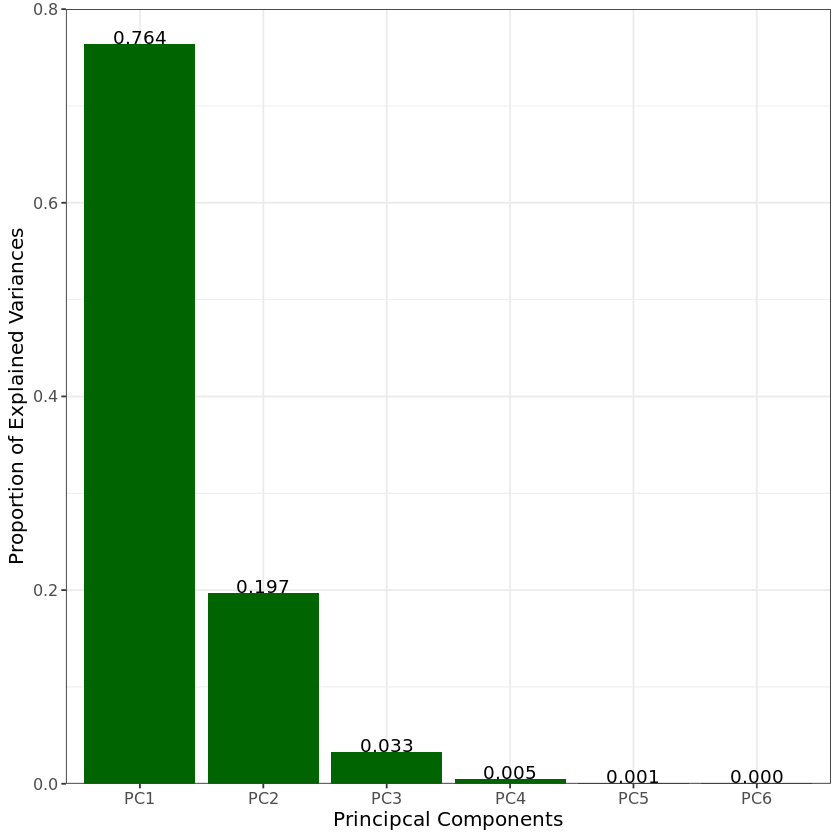

In [7]:
## calculate variances within each components
pca_vars <- (sapply(pca_trainData_X, sd))^2
total_vars <- sum(pca_vars)

## calculate the percentage of the variance explained by each components
explained_var_perc <- data.frame(Components = colnames(pca_trainData_X),
                                 Explained_var = pca_vars / total_vars)

## Now we can plot out the explained variances of the PCA. 
explained_var_perc %>% ggplot(aes(Components, Explained_var)) + 
    geom_bar(fill="darkgreen", stat = "identity") + 
    scale_y_continuous(breaks=seq(0,0.8,0.2), expand=c(0,0), limits = c(0,0.8)) +
    geom_text(aes(label=sprintf("%.3f",Explained_var)), vjust=0) +
    labs(x = "Principcal Components", y = "Proportion of Explained Variances") +
    theme_bw() + theme(text=element_text(size=12))

It is apparent that the first two principle components can explain the majority of the variance in the features. Now, let's look at the 
new pair wise scatter plot of the PCA data for the first three components which explains 99% of the overall data variance.


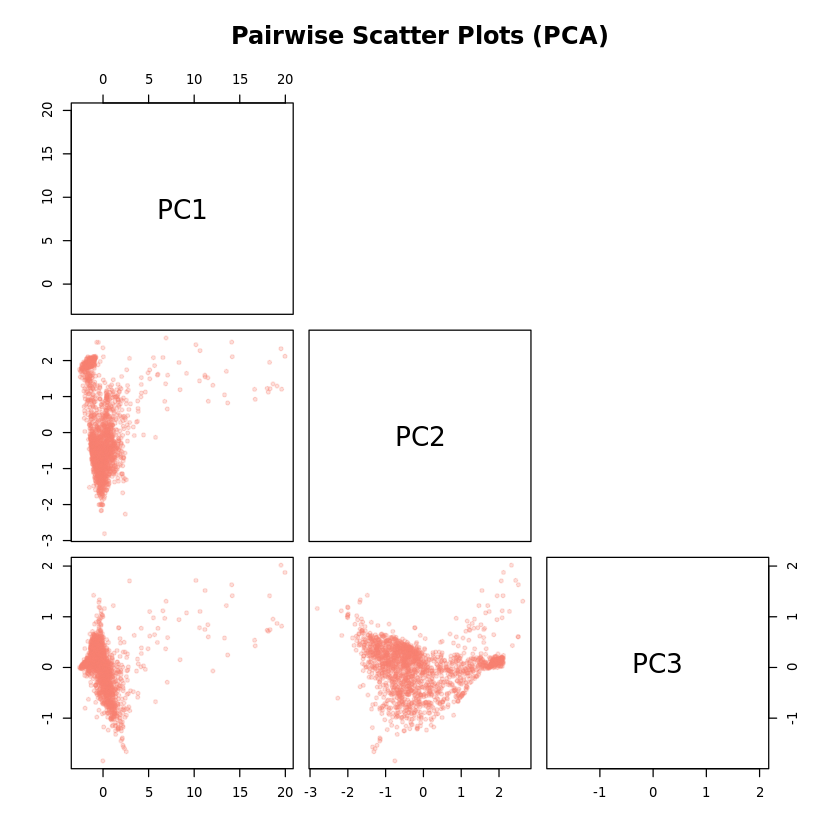

In [8]:
## In R base package, we can use the "pairs" function to visualize the pairwise scatter plot between each feature
## This pairwise scatter plot will inform us if there are any correlations amongst different features.
pca_trainData_X %>% select(PC1:PC3) %>% pairs(upper.panel=NULL, pch=20, 
                                              main="Pairwise Scatter Plots (PCA)",
                                              col=rgb(250/255., 128/255., 114/255., 0.25))  ## We use rgb() function to increase the 
                                                                                            ## transparency of the salmon color


### Exercise 1 - Examining separability of different classes

Can you create a scatter plot between PC1 and PC2 to examine the seperability amongst the four target classes in our data (i.e., forest, crop,
urban, and water)?

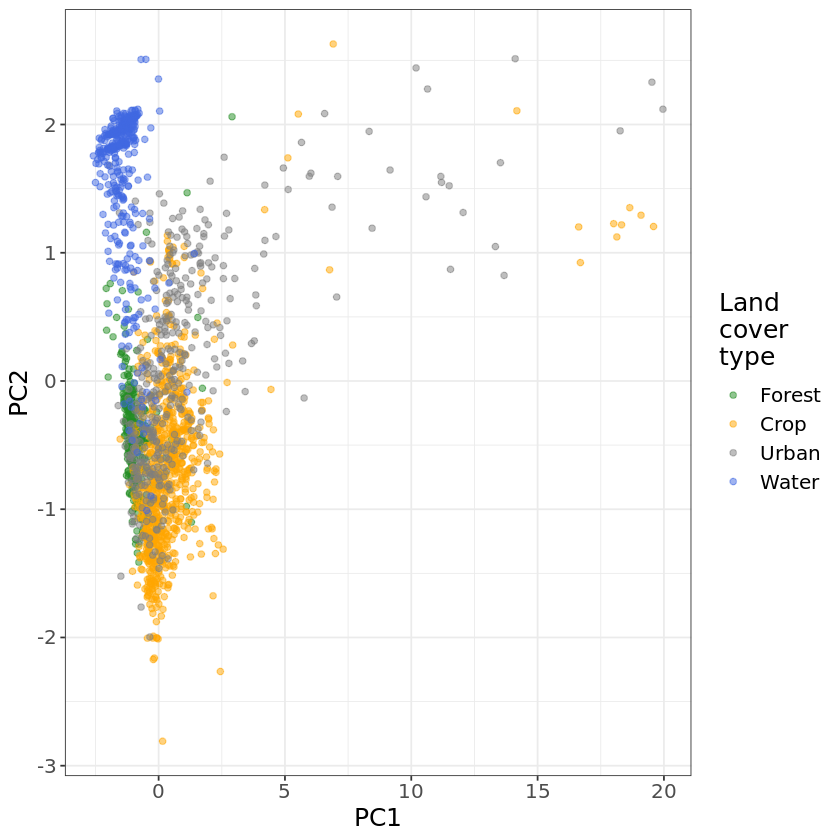

In [13]:
### With the transformed data after PCA, we can create a data frame containing the PCA transformed 
### features and the merged classes.
pca_dataframe = data.frame(merged_class = trainData$merged_class,
                           pca_trainData_X)

### With this data frame, we can create a scatter plot using merged_class to color our data points
### using ggplot function.
### The color list you can use is forest - "darkforest", crop - "orange", urban - "grey50", water - "royalblue"
### To avoid point overlapping, you can set the alpha value equal to 0.5 or less.
pca_dataframe %>% ggplot(aes(PC1, PC2)) + theme_bw() +
    geom_point(aes(color=merged_class), alpha=0.5, pch=19) +
    scale_color_manual(values = c("forestgreen", "orange", "grey50", "royalblue"),
                       name="Land \ncover \ntype") +
    theme(text=element_text(size=15))

### What do you see from the color coded scatter plot?

## 3 - Decision Tree  

In this section, we are going to implement a multiclass classifier using decision tree model. Decision tree model is the most intuitive 
tree-based machine learning model for both classification and regression problems. The most popular implementation of decision tree model is 
CART (Classification And Regression Tree). It recursively partitions the data via some decision rules based on the input features to predict 
a categorical (classification) or continuous (regression) outcome. All the decision rules are learned from the training datasets and will be 
applied to testing data and future new data for the model. More information about decision tree in machine learning can be found on [this 
website.](https://machinelearningmastery.com/classification-and-regression-trees-for-machine-learning/).  

In *caret* package, we are using the classic CART model for implement the multiclass classification applications. The tag for the CART model 
in *caret* is *"rpart"*. We can get more information about this model using *getModelInfo()* function in R.

In [14]:
getModelInfo("rpart", regex=FALSE)

parameter,class,label
<chr>,<chr>,<chr>
cp,numeric,Complexity Parameter


It looks like we can tune the complexity parameters (i.e., *cp*) for *"rpart"* which controls the learning process and the final structure of 
our decision tree model.  

First, let's define our training process via *trainControl()* function in *caret* package. 

In [15]:
## Define training process using trainControl function and here we are not using cross validation to change the parameter cp
dtCtrl <- trainControl(method="none")

params <- data.frame(cp=0.01) ## this is the default cp value 0.01

## Here our target outcome is the merged class
y_train <- trainData$merged_class; y_test <- testData$merged_class

## Now we want to only use the first three components from PCA for our model training
X_train <- pca_trainData_X[,1:3]

## train the model using train function
dtModel <- train(X_train, y_train, method="rpart", trControl=dtCtrl,
                 tuneGrid = params)

### 3.2 Visualizing a decision tree  

To better understand how a decision tree will look like directly, we can use the *rattle* package to do so.  

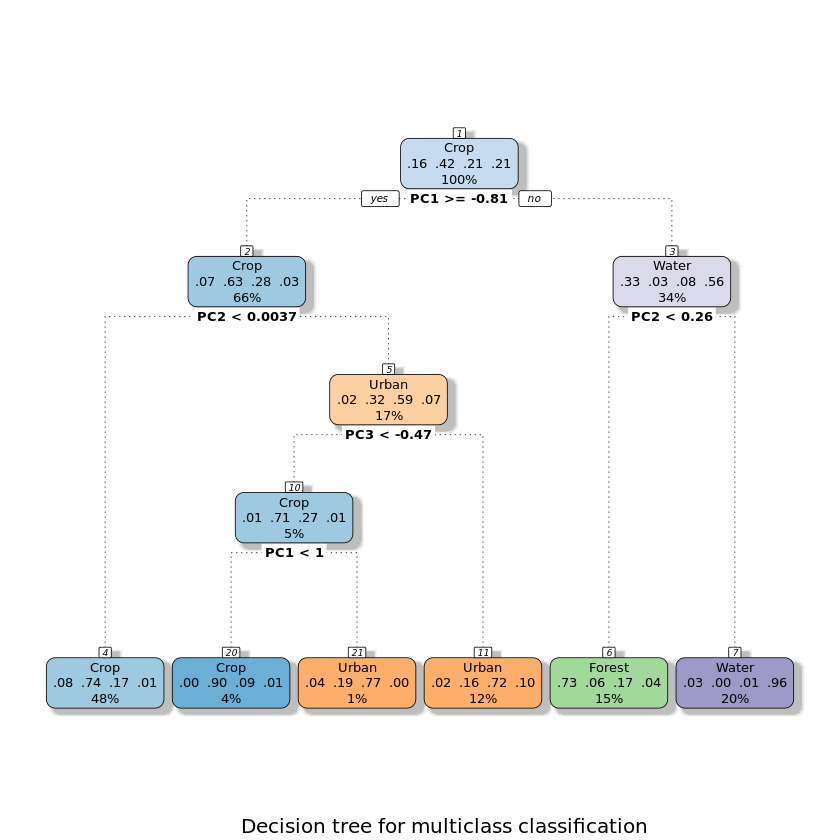

In [16]:
## In rattle plot, we can use facyRpartPlot() function to do so.
fancyRpartPlot(dtModel$finalModel, sub="Decision tree for multiclass classification")


From the structure of this decision tree, we can see which features were used at different nodes and which leaf node corresponds to different 
classes. 

### 3.3 Multiclass confusion matrix  

In this section, we will generate the confusion matrix for the decision tree multiclass classifier.  

In [17]:

## Calculate confusion matrix for the training results.
y_predicted_train <- predict(dtModel, newdata=X_train)
cfMatrix_train <- confusionMatrix(y_predicted_train, y_train)
cfMatrix_train

Confusion Matrix and Statistics

          Reference
Prediction Forest Crop Urban Water
    Forest    208   17    48    10
    Crop       76  740   161    11
    Urban       6   42   187    22
    Water      10    1     4   357

Overall Statistics
                                          
               Accuracy : 0.7853          
                 95% CI : (0.7661, 0.8035)
    No Information Rate : 0.4211          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.6878          
                                          
 Mcnemar's Test P-Value : < 2.2e-16       

Statistics by Class:

                     Class: Forest Class: Crop Class: Urban Class: Water
Sensitivity                 0.6933      0.9250      0.46750       0.8925
Specificity                 0.9531      0.7745      0.95333       0.9900
Pos Pred Value              0.7350      0.7490      0.72763       0.9597
Neg Pred Value              0.9431      0.9342    


We have an overall accuracy of 0.7874 for this four class classification with various performances for different classes. It appears that 
crop and urban / forest have some mix-ups during the classification.  

Now, we can apply this model to the independent testing data set and caculate for the confusion matrix.

In [18]:
## We first need to apply the PCA transformation to our testing data
pca_testData_X <- predict(preProcess_steps, newdata=testData_X)

## with the PCA test data, we can apply the decision tree model to it
y_predicted_test = predict(dtModel, newdata = pca_testData_X[,1:3])

## With the calculated y label for testing data, we can now calculate the confusion matrix
cfMatrix_test = confusionMatrix(y_predicted_test, y_test)

cfMatrix_test

Confusion Matrix and Statistics

          Reference
Prediction Forest Crop Urban Water
    Forest     49    3     8     2
    Crop       19  182    46     1
    Urban       1   15    45     8
    Water       6    0     1    89

Overall Statistics
                                          
               Accuracy : 0.7684          
                 95% CI : (0.7278, 0.8056)
    No Information Rate : 0.4211          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.6626          
                                          
 Mcnemar's Test P-Value : 2.551e-07       

Statistics by Class:

                     Class: Forest Class: Crop Class: Urban Class: Water
Sensitivity                 0.6533      0.9100      0.45000       0.8900
Specificity                 0.9675      0.7600      0.93600       0.9813
Pos Pred Value              0.7903      0.7339      0.65217       0.9271
Neg Pred Value              0.9370      0.9207    

### Bonus Exercise 2 - Using cross validation to explore the impact of *cp*

As we stated earlier, the complexity parameter (*cp*) of the model determines the structure/learning process of our decision tree.
Can you implement a 5-fold cross validation to find the optimum *cp* value for the model? This time, we can use the random search 
capability in *caret* with the function *train()* by specifying the key word *tuneLength=...*.  

In [19]:
### First, we need to define the training setting via the trainControl function.
### We need to specify the method for cross validation as well as how we want to do the search.
### This time, we are doing random search, which means we will set it as "random"
cvControl = trainControl(method="cv", number=5, search = "random")

### With the random search, we don't need to sepecify a parameter grid for the training process
### to search through. We only need sepecify the numer of random parameters we want it to 
### search using the key word "tuneLength=..." in train() function
### For us, let's say 10 times.
set.seed(1031)
dt_CV_random = train(X_train, y_train, method="rpart",
                     trControl = cvControl, tuneLength = 10)

### This shall give you the training results with 10 different *cp* values.
### You can look at the results by simply print it out
dt_CV_random

### Can you see what are the cp values that the random search has went through?
### What is the best cp value based on this random search?
### Can you apply this final model to our testing data to look at the confusion matrix?
y_predicted_random <- predict(dt_CV_random, newdata = pca_testData_X[,1:3])
cfMatrix_test_RandomSearch <- confusionMatrix(y_predicted_random, y_test)
cfMatrix_test_RandomSearch

CART 

1900 samples
   3 predictor
   4 classes: 'Forest', 'Crop', 'Urban', 'Water' 

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 1520, 1520, 1520, 1520, 1520 
Resampling results across tuning parameters:

  cp            Accuracy   Kappa    
  0.0000000000  0.7784211  0.6845374
  0.0002272727  0.7778947  0.6838034
  0.0003030303  0.7778947  0.6838034
  0.0009090909  0.7800000  0.6869563
  0.0011363636  0.7831579  0.6910396
  0.0013636364  0.7831579  0.6910396
  0.0021212121  0.7894737  0.6986367
  0.0027272727  0.7910526  0.7011379
  0.0045454545  0.7894737  0.6985469

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was cp = 0.002727273.

Confusion Matrix and Statistics

          Reference
Prediction Forest Crop Urban Water
    Forest     53    4    13     3
    Crop       14  178    34     0
    Urban       2   18    52     5
    Water       6    0     1    92

Overall Statistics
                                        
               Accuracy : 0.7895        
                 95% CI : (0.75, 0.8253)
    No Information Rate : 0.4211        
    P-Value [Acc > NIR] : < 2.2e-16     
                                        
                  Kappa : 0.6981        
                                        
 Mcnemar's Test P-Value : NA            

Statistics by Class:

                     Class: Forest Class: Crop Class: Urban Class: Water
Sensitivity                 0.7067      0.8900       0.5200       0.9200
Specificity                 0.9500      0.8255       0.9333       0.9813
Pos Pred Value              0.7260      0.7876       0.6753       0.9293
Neg Pred Value              0.9453      0.9116       0.8794       0.